In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D,Convolution2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

Using TensorFlow backend.


In [11]:
from PIL import Image
def load_data_vgg(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname = dir_data + identifier.astype(str) + '.tif'
        img = Image.open('training/0.tif')
        #resize to 224*224 for vgg model
        #img = img.resize((224, 224), Image.ANTIALIAS)
        img = (np.array(img)).astype(np.float32)
        #data.append((np.array(img)).astype(np.float32))
        data.append(img)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [12]:
train = load_data_vgg('training/','label/labels_training.csv')

In [13]:
test = load_data_vgg('testing/','submission.csv', training=False)

In [14]:
x_test = test[0]

In [15]:
#data pre-processing
x_train = train[0] #1500*224*224*3
y_train = train[1]
y_train = np_utils.to_categorical(y_train, num_classes=2)

In [8]:
#normalization
mean = x_train.mean()
std = x_train.std()

In [9]:
x_train_norm = (x_train - mean)/std
x_test_norm = (x_test - mean)/std

In [12]:
from keras.models import load_model
trainFromFloys = load_model('vggBlock5.h5')

In [16]:
predict = trainFromFloys.predict(x_test_norm)

In [19]:
(pd.DataFrame(predict)).to_csv('predict.csv')

In [ ]:
predict_class = trainFromFloys.predict_classes(x_test_norm)

In [12]:
#split training and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_norm, y_train, test_size=0.2, random_state=42)

In [13]:
#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

In [14]:
vggBlock5 = Sequential()
# Add the vgg convolutional base model
vggBlock5.add(vgg_conv)
# Add new layers
vggBlock5.add(Flatten())
vggBlock5.add(Dense(1024, activation='relu'))
vggBlock5.add(Dropout(0.5))
vggBlock5.add(Dense(2, activation='softmax'))

In [15]:
# Compile the model
from keras.optimizers import RMSprop
sgd = SGD(lr=1e-3, decay=0, momentum=0.9, nesterov=True)
vggBlock5.compile(loss='binary_crossentropy',
              #optimizer=RMSprop(lr=1e-4),
                optimizer = sgd,
              metrics=['acc'])

In [ ]:
print('Training ------------')#freeze
vggBlock5.fit(X_train, Y_train, epochs = 6, 
              batch_size = 32, shuffle = True, 
              validation_data=(X_valid, Y_valid)) 

Training ------------
Train on 1200 samples, validate on 300 samples
Epoch 1/6


In [30]:
#build fine-tuned VGG16 mode
from keras.applications.vgg16 import VGG16
vgg16_model = VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [31]:
type(vgg16_model)

keras.engine.training.Model

In [47]:
#convert pre-trained model to sequential one
model = Sequential()
for layer in vgg16_model.layers[:-1]: #not add the 1000 output layer
    model.add(layer)

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [49]:
for layer in model.layers:
    layer.trainable = False

In [50]:
model.add(Dense(2, activation='softmax'))

In [52]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

In [71]:
print('Training ------------')#freeze
model.fit(x_train, y_train, epochs = 12, batch_size = 64, shuffle = True, validation_split=0.2) 

Training ------------
Train on 1200 samples, validate on 300 samples
Epoch 1/12
1200/1200 [==============================] - 1028s 856ms/step - loss: 0.6426 - acc: 0.6667 - val_loss: 0.6544 - val_acc: 0.6500
Epoch 2/12
1200/1200 [==============================] - 27462s 23s/step - loss: 0.6391 - acc: 0.6667 - val_loss: 0.6501 - val_acc: 0.6500
Epoch 3/12
1200/1200 [==============================] - 1029s 858ms/step - loss: 0.6383 - acc: 0.6667 - val_loss: 0.6596 - val_acc: 0.6500
Epoch 4/12
1200/1200 [==============================] - 1210s 1s/step - loss: 0.6401 - acc: 0.6667 - val_loss: 0.6516 - val_acc: 0.6500
Epoch 5/12
1200/1200 [==============================] - 1453s 1s/step - loss: 0.6463 - acc: 0.6667 - val_loss: 0.6524 - val_acc: 0.6500
Epoch 6/12
1200/1200 [==============================] - 3620s 3s/step - loss: 0.6443 - acc: 0.6667 - val_loss: 0.6477 - val_acc: 0.6500
Epoch 7/12
1200/1200 [==============================] - 1061s 884ms/step - loss: 0.6409 - acc: 0.6667 - val

In [73]:
model.save('freezeAllVgg16.h5')

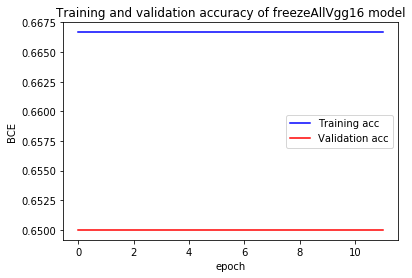

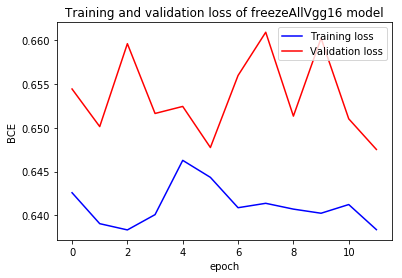

In [84]:
#check performance
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy of freezeAllVgg16 model')
plt.xlabel('epoch')
plt.ylabel('BCE')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of freezeAllVgg16 model')
plt.xlabel('epoch')
plt.ylabel('BCE')
plt.legend()
 
plt.show()

In [88]:
prob_vggfreezeall = model.predict_proba(x_test)

In [92]:
prob_vggfreezeall_1 = pd.DataFrame(prob_vggfreezeall[:,1])
prob_vggfreezeall_1.to_csv('vggfreezeall.csv')

In [ ]:
#alexnet: https://github.com/d2l-ai/d2l-zh/blob/master/chapter_convolutional-neural-networks/alexnet.md
net = 

In [11]:
#coding=utf-8
#zfnet model
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils.np_utils import to_categorical
import numpy as np
seed = 7
np.random.seed(seed)
 
zfnet = Sequential()
zfnet.add(Conv2D(96,(7,7),strides=(2,2),input_shape=(224,224,3),padding='valid',activation='relu',kernel_initializer='uniform'))
zfnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
zfnet.add(Conv2D(256,(5,5),strides=(2,2),padding='same',activation='relu',kernel_initializer='uniform'))
zfnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
zfnet.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
zfnet.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
zfnet.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
zfnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
zfnet.add(Flatten())
zfnet.add(Dense(4096,activation='relu'))
zfnet.add(Dropout(0.5))
zfnet.add(Dense(4096,activation='relu'))
zfnet.add(Dropout(0.5))
zfnet.add(Dense(2,activation='softmax'))
#sgd_opt = SGD(lr = 1e-4)
sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=1e-4, decay=0.0)
zfnet.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
#zfnet.summary()

In [12]:
print('Training ------------')#zfnet, optimization = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
zfnet.fit(x_train, y_train, epochs = 2, batch_size = 32, shuffle = True, validation_split=0.2) 

Training ------------
Train on 1200 samples, validate on 300 samples
Epoch 1/2
1200/1200 [==============================] - 191s 159ms/step - loss: 6.2788 - acc: 0.6050 - val_loss: 5.6106 - val_acc: 0.6500
Epoch 2/2
1200/1200 [==============================] - 499s 416ms/step - loss: 5.3434 - acc: 0.6667 - val_loss: 5.6106 - val_acc: 0.6500


In [126]:
zfnet.save('zfnetWithoutNormalization.h5')

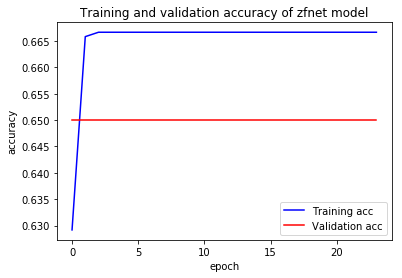

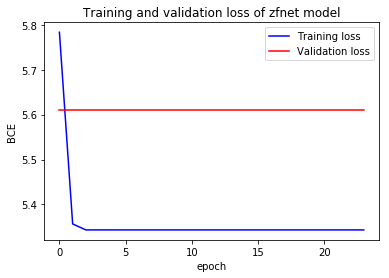

In [128]:
#check performance
acc = zfnet.history.history['acc']
val_acc = zfnet.history.history['val_acc']
loss = zfnet.history.history['loss']
val_loss = zfnet.history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy of zfnet model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of zfnet model')
plt.xlabel('epoch')
plt.ylabel('BCE')
plt.legend()
 
plt.show()

In [42]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        'training_copy/Generator_Train/',
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='binary')
 
validation_generator = validation_datagen.flow_from_directory(
        'training_copy/Generator_Valid/',
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='binary',
        shuffle=False)

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 2 classes.


In [9]:
#data pre-processing
x_train = train[0] #1500*101*101*3
y_train = train[1]
x_train = x_train.astype('float32')
x_train /= 255
y_train = np_utils.to_categorical(y_train, num_classes=2)

In [10]:
x_test = test[0] #558, 101, 101, 3

In [8]:
img_rows = 101
img_cols = 101
channels = 3

In [20]:
#build model
model = Sequential()
#Conv layer1 output 
model.add(Convolution2D(input_shape = (img_rows, img_cols, channels),filters = 32,kernel_size = 5,
                        strides = 1,padding = 'same'))
#activation function
model.add(Activation('relu'))
#pooling layer1 (max pooling)
model.add(MaxPooling2D(pool_size = 2,strides = 2,padding = 'same'))
#Conv layer2
model.add(Convolution2D(filters = 32,kernel_size = 5,strides = 1,padding = 'same'))
#activation function
model.add(Activation('relu'))
#pooling layer2 (max pooling)
model.add(MaxPooling2D(pool_size = 2,strides = 2,padding = 'same'))
#Conv layer3
model.add(Convolution2D(filters = 32,kernel_size = 5,strides = 1,padding = 'same'))
#activation function
model.add(Activation('relu'))
#pooling layer3 (max pooling)
model.add(MaxPooling2D(pool_size = 2,strides = 2,padding = 'same'))
#drop out
#model.add(Dropout(0.25))
#fully connected layer1
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
#fully connected layer2 
#model.add(Dropout(0.25))
model.add(Dense(2))
model.add(Activation('softmax'))
#define the optimizer
adam = Adam(lr = 1e-4)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#metrics
model.compile(optimizer =sgd,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [115]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)
prob = model.predict_proba(x_test)

In [117]:
prob_1 = pd.DataFrame(prob[:,1])

In [125]:
result = pd.read_csv('submission.csv')

In [121]:
np.set_printoptions(suppress=True)
prob_1.to_csv('result.csv')

In [23]:
print('Training ------------')
model.fit(x_train, y_train, epochs = 24, batch_size = 32, shuffle = True, validation_split=0.2) #lr=1e-4

Training ------------
Train on 1200 samples, validate on 300 samples
Epoch 1/24
1200/1200 [==============================] - 31s 26ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 2/24
1200/1200 [==============================] - 29s 24ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 3/24
1200/1200 [==============================] - 30s 25ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 4/24
1200/1200 [==============================] - 28s 24ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 5/24
1200/1200 [==============================] - 33s 27ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 6/24
1200/1200 [==============================] - 28s 24ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 7/24
1200/1200 [==============================] - 30s 25ms/step - loss: 5.3727 - acc: 0.6667 - val_loss: 5.64

In [80]:
print('Training ------------')
model.fit(x_train, y_train, epochs = 24, batch_size = 128) #lr=1e-4, 3 conv layers

Training ------------
Epoch 1/24
1500/1500 [==============================] - 36s 24ms/step - loss: 0.5405 - acc: 0.7433
Epoch 2/24
1500/1500 [==============================] - 36s 24ms/step - loss: 0.5256 - acc: 0.7520
Epoch 3/24
1500/1500 [==============================] - 35s 23ms/step - loss: 0.5035 - acc: 0.7720
Epoch 4/24
1500/1500 [==============================] - 33s 22ms/step - loss: 0.5096 - acc: 0.7620
Epoch 5/24
1500/1500 [==============================] - 35s 23ms/step - loss: 0.4850 - acc: 0.7840
Epoch 6/24
1500/1500 [==============================] - 37s 25ms/step - loss: 0.4978 - acc: 0.7560
Epoch 7/24
1500/1500 [==============================] - 49s 32ms/step - loss: 0.4677 - acc: 0.7973
Epoch 8/24
1500/1500 [==============================] - 38s 25ms/step - loss: 0.4551 - acc: 0.8053
Epoch 9/24
1500/1500 [==============================] - 40s 26ms/step - loss: 0.4487 - acc: 0.8020
Epoch 10/24
1500/1500 [==============================] - 40s 26ms/step - loss: 0.4567 -

In [41]:
res = pd.read_csv('/Users/meteor.lxy/Desktop/resnet.csv')

In [42]:
res

,epoch,train_loss,valid_loss,accuracy
0,1,0.021245,0.123908,0.980000
1,2,0.011410,0.088947,0.986667
2,3,0.007762,0.075918,0.990000
3,4,0.008306,0.109976,0.986667
4,5,0.007533,0.078560,0.980000
5,6,0.010514,0.079959,0.986667
6,7,0.008497,0.074331,0.990000
7,8,0.007908,0.094478,0.986667
8,9,0.008733,0.103178,0.990000
9,10,0.007292,0.086293,0.990000


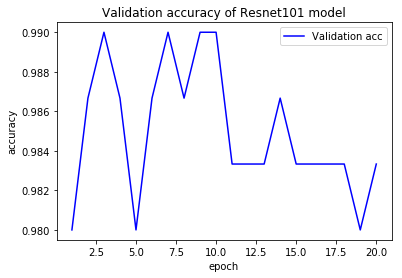

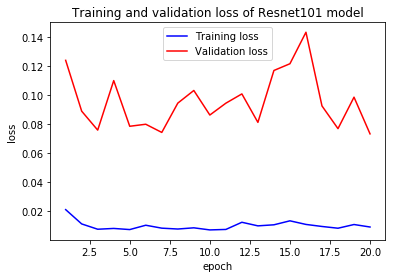

In [47]:
epochs = range(len(res))
plt.plot(res['epoch'], res['accuracy'], 'b', label='Validation acc')
plt.title('Validation accuracy of Resnet101 model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(res['epoch'], res['train_loss'], 'b', label='Training loss')
plt.plot(res['epoch'], res['valid_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss of Resnet101 model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
 
plt.show()

In [51]:
compare = pd.read_csv('/Users/meteor.lxy/Desktop/compare.csv')

In [52]:
compare

,Name,Score
0,Scratch,0.64966
1,VGG16,0.97428
2,Resnet101,0.98963


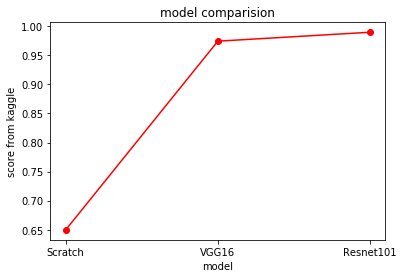

In [57]:
plt.plot(compare['Name'],compare['Score'],'ro-')
plt.xlabel('model')
plt.ylabel('score from kaggle')
plt.title('model comparision')
plt.show()

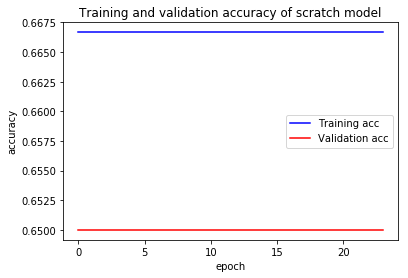

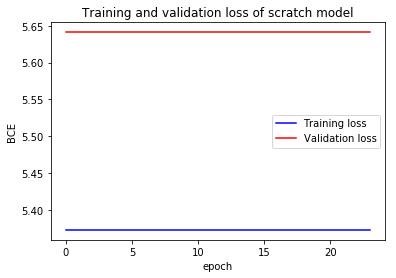

In [24]:
#check performance
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy of scratch model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss of scratch model')
plt.xlabel('epoch')
plt.ylabel('BCE')
plt.legend()
 
plt.show()

In [27]:
pred_prob = model.predict_proba(x_test)

In [33]:
pd.read_csv('~/Desktop/baseline.csv')

,id,Score
0,1500,1.000000e+00
1,1501,1.000000e+00
2,1502,1.000000e+00
3,1503,1.000000e+00
4,1504,1.000000e+00
5,1505,0.000000e+00
6,1506,1.000000e+00
7,1507,1.000000e+00
8,1508,1.000000e+00
9,1509,1.000000e+00
